1. Imports & Environment Setup

In [1]:
import pandas as pd
import numpy as np
import re
import nltk
import warnings
warnings.filterwarnings("ignore")


from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk import word_tokenize, pos_tag
from nltk.chunk import RegexpParser
from collections import Counter, defaultdict
import matplotlib.pyplot as plt


# Download required NLTK resources (run once)
nltk.download("stopwords")
nltk.download("wordnet")
nltk.download("omw-1.4")
nltk.download("punkt")
nltk.download("punkt_tab")
nltk.download("averaged_perceptron_tagger")
nltk.download("averaged_perceptron_tagger_eng")

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Hi\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Hi\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\Hi\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Hi\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\Hi\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\Hi\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloadi

True

2. Data Loading

In [2]:
file_path = r"C:\Users\Hi\Downloads\PYTHON\FINAL PROJECT\aspect-based-sentiment-analysis\Dataset.csv"


df = pd.read_csv(file_path, encoding="latin1")
print("Dataset loaded:", df.shape)


df.head()

Dataset loaded: (363261, 5)


,Product_name,Price,Rate,Review,Summary
0,"Crompton 75 L Desert Air Cooler??(White, Tea...","??10,499",5,Simply awesome,it's really worth every single penny. it works...
1,"Crompton 75 L Desert Air Cooler??(White, Tea...","??10,499",4,Worth the money . Desert Cooler live up to the...,I bought Crompton Ozone 75 Desert Air Cooler i...
2,"Crompton 75 L Desert Air Cooler??(White, Tea...","??10,499",5,Worth every penny,GREAT packaging by seller. As this was the mos...
3,"Crompton 75 L Desert Air Cooler??(White, Tea...","??10,499",5,Fabulous!,Delivery was delayed by two days except this e...
4,"Crompton 75 L Desert Air Cooler??(White, Tea...","??10,499",4,Nice product,A Good cooler by Crompton. The height of the c...


3. Initial Data Understanding (EDA – Core)

In [3]:
print(df.columns)
df.info()


# Missing value check
df.isnull().sum()

Index(['Product_name', 'Price', 'Rate', 'Review', 'Summary'], dtype='object')
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 363261 entries, 0 to 363260
Data columns (total 5 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   Product_name  363246 non-null  object
 1   Price         363245 non-null  object
 2   Rate          363245 non-null  object
 3   Review        363239 non-null  object
 4   Summary       361239 non-null  object
dtypes: object(5)
memory usage: 13.9+ MB


Product_name      15
Price             16
Rate              16
Review            22
Summary         2022
dtype: int64

4. Data Cleaning

In [4]:
# Drop rows missing critical fields
df = df.dropna(subset=["Summary", "Rate"])


# Fix rating column
df["Rate"] = pd.to_numeric(df["Rate"], errors="coerce")
df = df.dropna(subset=["Rate"])
df["Rate"] = df["Rate"].astype(int)


# Verify rating distribution
df["Rate"].value_counts().sort_index()

Rate
1     39892
2     12905
3     31871
4     73860
5    202705
Name: count, dtype: int64

5. Feature Engineering (Text)

In [6]:
# Combine short review and detailed summary
df["full_review"] = df["Review"].fillna("") + " " + df["Summary"]


df[["Review", "Summary", "full_review"]].head()

,Review,Summary,full_review
0,Simply awesome,it's really worth every single penny. it works...,Simply awesome it's really worth every single ...
1,Worth the money . Desert Cooler live up to the...,I bought Crompton Ozone 75 Desert Air Cooler i...,Worth the money . Desert Cooler live up to the...
2,Worth every penny,GREAT packaging by seller. As this was the mos...,Worth every penny GREAT packaging by seller. A...
3,Fabulous!,Delivery was delayed by two days except this e...,Fabulous! Delivery was delayed by two days exc...
4,Nice product,A Good cooler by Crompton. The height of the c...,Nice product A Good cooler by Crompton. The he...


6. Sentiment Label Creation

In [8]:
def map_sentiment(rating):

    if rating <= 2:

        return "Negative"

    elif rating == 3:

        return "Neutral"

    else:

        return "Positive"



df["sentiment"] = df["Rate"].apply(map_sentiment)

df["sentiment"].value_counts()


sentiment
Positive    276565
Negative     52797
Neutral      31871
Name: count, dtype: int64

7. Text Preprocessing

In [9]:
stop_words = set(stopwords.words("english"))

lemmatizer = WordNetLemmatizer()



def preprocess_text(text):

    text = text.lower()

    text = re.sub(r"http\S+|www\S+", "", text)

    text = re.sub(r"[^a-z\s]", "", text)

    text = re.sub(r"\s+", " ", text).strip()

    tokens = text.split()

    tokens = [lemmatizer.lemmatize(word) for word in tokens if word not in stop_words]

    return " ".join(tokens)





df["processed_review"] = df["full_review"].apply(preprocess_text)

df[["full_review", "processed_review"]].head()

,full_review,processed_review
0,Simply awesome it's really worth every single ...,simply awesome really worth every single penny...
1,Worth the money . Desert Cooler live up to the...,worth money desert cooler live name bought cro...
2,Worth every penny GREAT packaging by seller. A...,worth every penny great packaging seller impor...
3,Fabulous! Delivery was delayed by two days exc...,fabulous delivery delayed two day except every...
4,Nice product A Good cooler by Crompton. The he...,nice product good cooler crompton height coole...


8. Aspect Extraction (NLP Core)

In [10]:
grammar = r"""

  NP: {<JJ>*<NN.*>+}

"""



chunk_parser = RegexpParser(grammar)



def extract_aspects(text):

    tokens = word_tokenize(text)

    pos_tags = pos_tag(tokens)

    tree = chunk_parser.parse(pos_tags)



    aspects = []

    for subtree in tree.subtrees(filter=lambda t: t.label() == "NP"):

        aspect = " ".join(word for word, tag in subtree.leaves())

        aspects.append(aspect)

    return aspects

9. Aspect Extraction on Sample (Scalable Design)

In [11]:
sample_df = df.sample(1000, random_state=42)
sample_df["aspects"] = sample_df["processed_review"].apply(extract_aspects)


sample_df[["processed_review", "aspects"]].head()

,processed_review,aspects
61432,must buy good,[]
341670,excellent good product,[excellent good product]
148889,super good product high quality good packing,"[super good product, high quality, good packing]"
11931,must buy good material usedafter one month use...,"[good material usedafter, month, iam]"
138029,slightly disappointed satisfied heat,[heat]


10. Aspect Frequency Analysis

In [12]:
all_aspects = [a for aspects in sample_df["aspects"] for a in aspects]
aspect_counts = Counter(all_aspects)


aspect_counts.most_common(20)

[('good product', 44),
 ('nice product', 38),
 ('product', 29),
 ('penny', 25),
 ('good quality product', 22),
 ('terrific purchase', 21),
 ('market', 20),
 ('classy product', 19),
 ('great product', 18),
 ('worth money', 17),
 ('perfect product', 16),
 ('purchase', 16),
 ('good choice', 13),
 ('good good', 11),
 ('valueformoney', 11),
 ('terrible product', 10),
 ('good quality', 10),
 ('job', 8),
 ('wow', 8),
 ('waste money', 7)]

11. Aspect-Based Sentiment Analysis

In [13]:
aspect_sentiment = defaultdict(list)



for _, row in sample_df.iterrows():

    for aspect in row["aspects"]:

        aspect_sentiment[aspect].append(row["sentiment"])



aspect_summary = {}

for aspect, sentiments in aspect_sentiment.items():

    aspect_summary[aspect] = Counter(sentiments)



aspect_sentiment_df = pd.DataFrame(aspect_summary).T.fillna(0).astype(int)

aspect_sentiment_df.head()

,Positive,Neutral,Negative
excellent good product,3,0,0
super good product,2,0,0
high quality,1,0,0
good packing,1,1,0
good material usedafter,1,0,0


12. Aspect Normalization (Business Mapping)

In [14]:
def normalize_aspect(aspect):

    if "product" in aspect or "quality" in aspect:

        return "Product Quality"

    elif any(word in aspect for word in ["money", "penny", "value"]):

        return "Value for Money"

    elif "delivery" in aspect:

        return "Delivery"

    elif "pack" in aspect:

        return "Packaging"

    elif any(word in aspect for word in ["purchase", "market"]):

        return "Purchase Experience"

    else:

        return "Other"



aspect_sentiment_df["normalized_aspect"] = aspect_sentiment_df.index.map(normalize_aspect)



final_aspect_summary = (

    aspect_sentiment_df

    .groupby("normalized_aspect")[["Positive", "Neutral", "Negative"]]

    .sum()

    .sort_values(by="Positive", ascending=False)

)



final_aspect_summary

,Positive,Neutral,Negative
normalized_aspect,,,
Other,753,130,198
Product Quality,441,47,101
Value for Money,98,0,31
Purchase Experience,88,0,4
Delivery,11,2,1
Packaging,10,2,0


13. Visualization

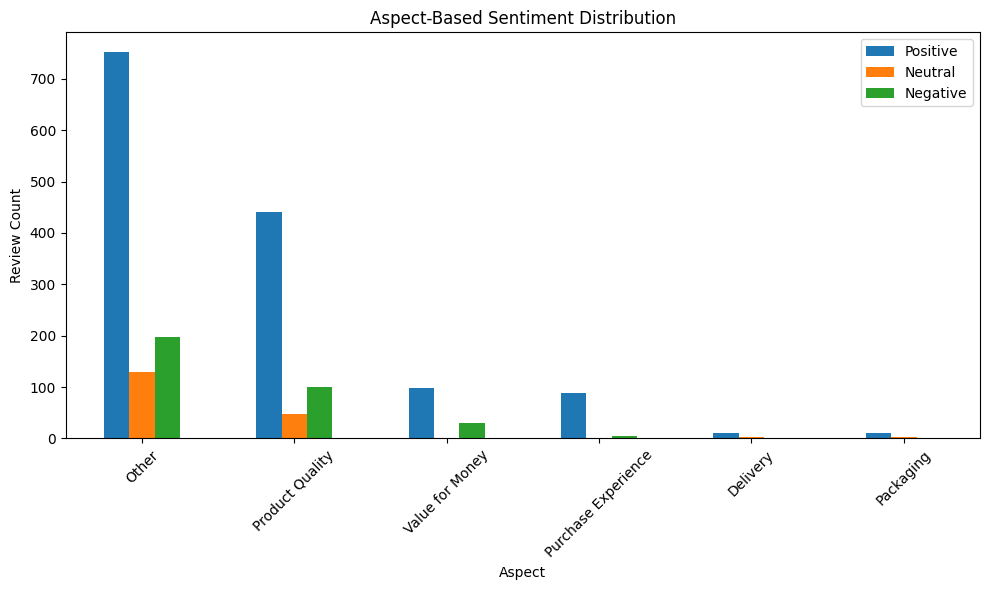

In [15]:
final_aspect_summary.plot(kind="bar", figsize=(10, 6))
plt.title("Aspect-Based Sentiment Distribution")
plt.xlabel("Aspect")
plt.ylabel("Review Count")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()